In [53]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from geopy import distance
import openmeteo_requests
import requests
import requests_cache
from retry_requests import retry
from dotenv import load_dotenv

load_dotenv()

XCLIENTID = os.getenv('XCLIENTID')
PASSKEY = os.getenv('PASSKEY')


sns.set()

jsons = ['202210.json', '202211.json', '202212.json']
data = []
# Load the data from the file
for file in jsons:
    with open(file) as f:
        for line in f:
            data.append(json.loads(line))

In [25]:
data[0]

{'_id': '2022-10-01T00:05:05.771548',
 'stations': [{'activate': 1,
   'name': 'Puerta del Sol A',
   'reservations_count': 0,
   'light': 2,
   'total_bases': 30,
   'free_bases': 9,
   'number': '1a',
   'longitude': '-3.7018341',
   'no_available': 0,
   'address': 'Puerta del Sol nº 1',
   'latitude': '40.4172137',
   'dock_bikes': 18,
   'id': 1},
  {'activate': 1,
   'name': 'Puerta del Sol B',
   'reservations_count': 0,
   'light': 2,
   'total_bases': 30,
   'free_bases': 9,
   'number': '1b',
   'longitude': '-3.701602938060457',
   'no_available': 0,
   'address': 'Puerta del Sol nº 1',
   'latitude': '40.41731271011562',
   'dock_bikes': 17,
   'id': 2},
  {'activate': 1,
   'name': 'Miguel Moya',
   'reservations_count': 0,
   'light': 2,
   'total_bases': 24,
   'free_bases': 15,
   'number': '2',
   'longitude': '-3.7058415',
   'no_available': 0,
   'address': 'Calle Miguel Moya nº 1',
   'latitude': '40.4205886',
   'dock_bikes': 8,
   'id': 3},
  {'activate': 1,
   'n

In [2]:
stations = pd.DataFrame()
already_in = []
keep_cols = ['id', 'name', 'number', 'address', 'latitude', 'longitude', 'total_bases']

# data is a list of dictionaries. Each dictionary has a key 'stations' which is a list of dictionaries. Each of these dictionaries has a key 'name', 'number', 'longitude', 'address', 'latitude', 'id'
for d in data:
    for station in d['stations']:
        if station['id'] not in already_in:
            # stations = stations.append(station, ignore_index=True)
            # already_in.append(station['id'])
            # Use pandas.concat instead of append
            stations = pd.concat([stations, pd.DataFrame(station, index=[0], columns=keep_cols)], ignore_index=True)
            already_in.append(station['id'])

stations.set_index('id', inplace=True)


In [10]:
stations

,name,number,address,latitude,longitude,total_bases
id,,,,,,
1,Puerta del Sol A,1a,Puerta del Sol nº 1,40.4172137,-3.7018341,30
2,Puerta del Sol B,1b,Puerta del Sol nº 1,40.41731271011562,-3.701602938060457,30
3,Miguel Moya,2,Calle Miguel Moya nº 1,40.4205886,-3.7058415,24
4,Plaza Conde Suchil,3,Plaza del Conde del Valle de Súchil nº 3,40.4302937,-3.7069171,18
5,Malasaña,4,Calle Manuela Malasaña nº 5,40.4285524,-3.7025875,24
...,...,...,...,...,...,...
265,INEF,257,Avenida Juan de Herrera frente a la calle Paul...,40.43896,-3.72997,24
266,Ciudad Universitaria 1,258,Avenida de la Complutense (Metro Ciudad Univer...,40.44375,-3.72699,24
267,Ciudad Universitaria 2,259,Avenida de la Complutense (Metro Ciudad Univer...,40.44342,-3.72693,24


In [3]:
station_ids = stations.index.values
stations_time_series = pd.DataFrame(index=station_ids)
data_list = []

for d in data:
    date = pd.to_datetime(d['_id'])
    dock_bikes_dict = {}
    for station in d['stations']:
        dock_bikes_dict[station['id']] = station['dock_bikes']
    
    data_list.append(pd.Series(dock_bikes_dict, name=date))

stations_time_series = pd.concat(data_list, axis=1).T

In [101]:
stations_time_series

,1,2,3,4,5,6,7,8,9,10,...,260,261,262,263,264,265,266,267,268,269
2022-10-01 00:05:05.771548,18,17,8,15,4,16,10,18,13,14,...,9,6,3,3,2,1,0,2,2,7
2022-10-01 01:05:08.526286,15,17,4,10,2,11,8,16,13,15,...,7,6,6,3,3,2,2,2,2,8
2022-10-01 02:05:09.305373,12,15,4,8,4,9,11,12,10,14,...,6,6,6,3,4,1,2,2,2,8
2022-10-01 03:05:10.046779,9,11,4,9,4,8,9,5,2,13,...,6,6,5,3,4,1,2,2,2,8
2022-10-01 04:05:11.827629,5,10,3,9,2,2,6,4,2,13,...,5,6,5,2,6,1,2,2,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:57:50.302819,0,0,6,2,2,1,3,5,5,16,...,11,13,16,8,14,9,4,14,9,14
2022-12-31 20:57:50.382304,0,0,6,2,0,1,2,3,6,15,...,12,13,17,15,14,9,4,15,9,14
2022-12-31 21:57:52.761035,0,0,7,1,0,2,2,2,5,13,...,11,14,18,16,15,9,4,15,9,14
2022-12-31 22:57:53.608384,0,0,9,2,0,1,2,2,7,14,...,11,14,18,16,15,9,4,15,9,14


In [73]:
min(stations_time_series.index - stations_time_series.index.round('H'))

Timedelta('-1 days +23:30:01.295970')

In [91]:
# Check for missing hours
c = 0
for i in range(len(stations_time_series.index) - 1):
    if stations_time_series.index[i].floor('H') + pd.Timedelta('1H') != stations_time_series.index[i+1].floor('H'):
        print(stations_time_series.index[i], stations_time_series.index[i+1])
        c += 1

c

2022-10-06 11:08:44.804859 2022-10-06 13:09:05.331207
2022-10-12 02:32:24.150208 2022-10-12 04:42:44.238360
2022-10-12 05:52:31.607188 2022-10-12 07:04:21.314889
2022-10-12 07:04:21.314889 2022-10-12 09:08:18.873391
2022-10-12 13:07:00.224708 2022-10-12 13:07:08.664637
2022-10-12 13:07:08.664637 2022-10-12 13:07:16.308844
2022-10-14 12:08:17.275416 2022-10-14 14:08:19.057005
2022-10-20 12:12:01.400663 2022-10-20 15:12:06.039722
2022-11-02 15:20:15.106406 2022-11-02 18:20:19.687518
2022-11-08 11:24:03.720105 2022-11-08 13:24:06.180915
2022-12-17 00:48:22.839191 2022-12-17 09:48:35.094797
2022-12-18 11:49:17.565507 2022-12-18 22:49:34.532901
2022-12-20 12:50:41.568894 2022-12-20 14:50:46.842706


13

In [92]:
# Check for missing hours
c = 0
for i in range(len(stations_time_series.index) - 1):
    if stations_time_series.index[i].round('H') + pd.Timedelta('1H') != stations_time_series.index[i+1].round('H'):
        print(stations_time_series.index[i], stations_time_series.index[i+1])
        c += 1

c

2022-10-06 11:08:44.804859 2022-10-06 13:09:05.331207
2022-10-12 01:26:09.501469 2022-10-12 02:32:24.150208
2022-10-12 02:32:24.150208 2022-10-12 04:42:44.238360
2022-10-12 07:04:21.314889 2022-10-12 09:08:18.873391
2022-10-12 13:07:00.224708 2022-10-12 13:07:08.664637
2022-10-12 13:07:08.664637 2022-10-12 13:07:16.308844
2022-10-14 12:08:17.275416 2022-10-14 14:08:19.057005
2022-10-20 12:12:01.400663 2022-10-20 15:12:06.039722
2022-11-02 15:20:15.106406 2022-11-02 18:20:19.687518
2022-11-08 11:24:03.720105 2022-11-08 13:24:06.180915
2022-11-18 05:29:58.919620 2022-11-18 06:30:01.295970
2022-12-17 00:48:22.839191 2022-12-17 09:48:35.094797
2022-12-18 11:49:17.565507 2022-12-18 22:49:34.532901
2022-12-20 12:50:41.568894 2022-12-20 14:50:46.842706


14

In [57]:
stations_time_series.index = stations_time_series.index.round('H')

In [58]:
stations_time_series

,1,2,3,4,5,6,7,8,9,10,...,260,261,262,263,264,265,266,267,268,269
2022-10-01 00:00:00,18,17,8,15,4,16,10,18,13,14,...,9,6,3,3,2,1,0,2,2,7
2022-10-01 01:00:00,15,17,4,10,2,11,8,16,13,15,...,7,6,6,3,3,2,2,2,2,8
2022-10-01 02:00:00,12,15,4,8,4,9,11,12,10,14,...,6,6,6,3,4,1,2,2,2,8
2022-10-01 03:00:00,9,11,4,9,4,8,9,5,2,13,...,6,6,5,3,4,1,2,2,2,8
2022-10-01 04:00:00,5,10,3,9,2,2,6,4,2,13,...,5,6,5,2,6,1,2,2,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 20:00:00,0,0,6,2,2,1,3,5,5,16,...,11,13,16,8,14,9,4,14,9,14
2022-12-31 21:00:00,0,0,6,2,0,1,2,3,6,15,...,12,13,17,15,14,9,4,15,9,14
2022-12-31 22:00:00,0,0,7,1,0,2,2,2,5,13,...,11,14,18,16,15,9,4,15,9,14
2022-12-31 23:00:00,0,0,9,2,0,1,2,2,7,14,...,11,14,18,16,15,9,4,15,9,14


In [8]:
# Plot in a map the stations
# Create a map
m = folium.Map(location=[40.416775, -3.703790], zoom_start=12)

# Add points to the map
for index, row in stations.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['name']).add_to(m)

# Display the map
m

In [103]:
station_index = stations[stations.name=='Puerta de Madrid'].index[0]
station = stations.loc[station_index]
time_series = stations_time_series[station_index]

In [137]:
station

name                                            Puerta de Madrid
number                                                        85
address        Avenida de Menéndez Pelayo esquina calle O'Don...
latitude                                              40.4215010
longitude                                             -3.6800080
total_bases                                                   27
distance                                                     0.0
Name: 90, dtype: object

NameError: name 'time_series' is not defined

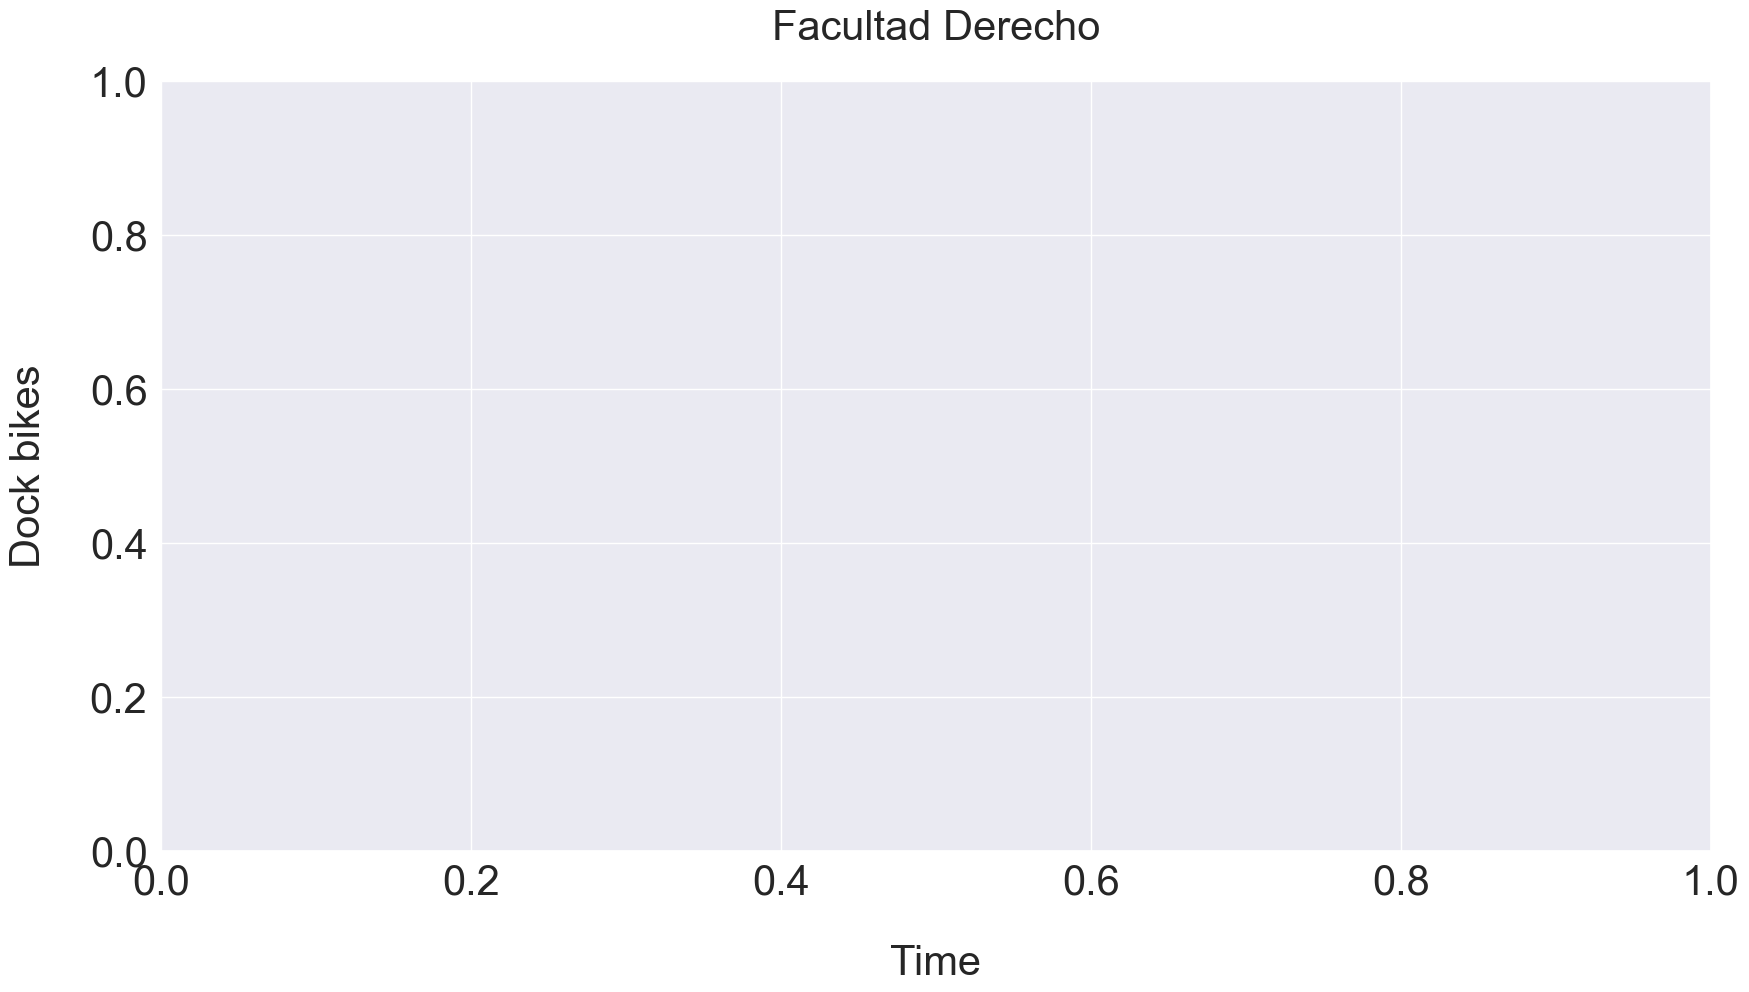

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.titlepad'] = 30
# Set the size of the x-axis label
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.labelpad'] = 30
# Set the size of the ticks
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.figure(figsize=(20,10))
plt.ylabel('Dock bikes')
plt.xlabel('Time')
plt.title(station['name'])
# Set the size of the title

time_series.plot()

In [136]:
# Plot all the stations in a map
# Create a map
m = folium.Map(location=[40.416775, -3.703790], zoom_start=12)

# Add points to the map
for index, row in stations.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['name'], icon=folium.Icon(color='blue', icon='fa-bicycle', prefix='fa')).add_to(m)

# Display the map
m


In [64]:
m = folium.Map(location=[station.latitude, station.longitude], zoom_start=16)

# Get the 5 nearest stations
distances = []
for index, row in stations.iterrows():
    distances.append(distance.distance((station.latitude, station.longitude), (row.latitude, row.longitude)).km)
stations['distance'] = distances
stations.sort_values('distance', inplace=True)
stations.head()

# Add points to the map

#First the station in red
folium.Marker(location=[station.latitude, station.longitude], popup=station['name'], icon=folium.Icon(color='red', icon='fa-bicycle', prefix='fa')).add_to(m)

# Then the 5 nearest stations in blue
for index, row in stations.iloc[1:6].iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['name'], icon=folium.Icon(color='blue', icon='fa-bicycle', prefix='fa')).add_to(m)

# Display the map
m

Coordinates 40.38664245605469°E -3.67608642578125°N
Elevation 688.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s


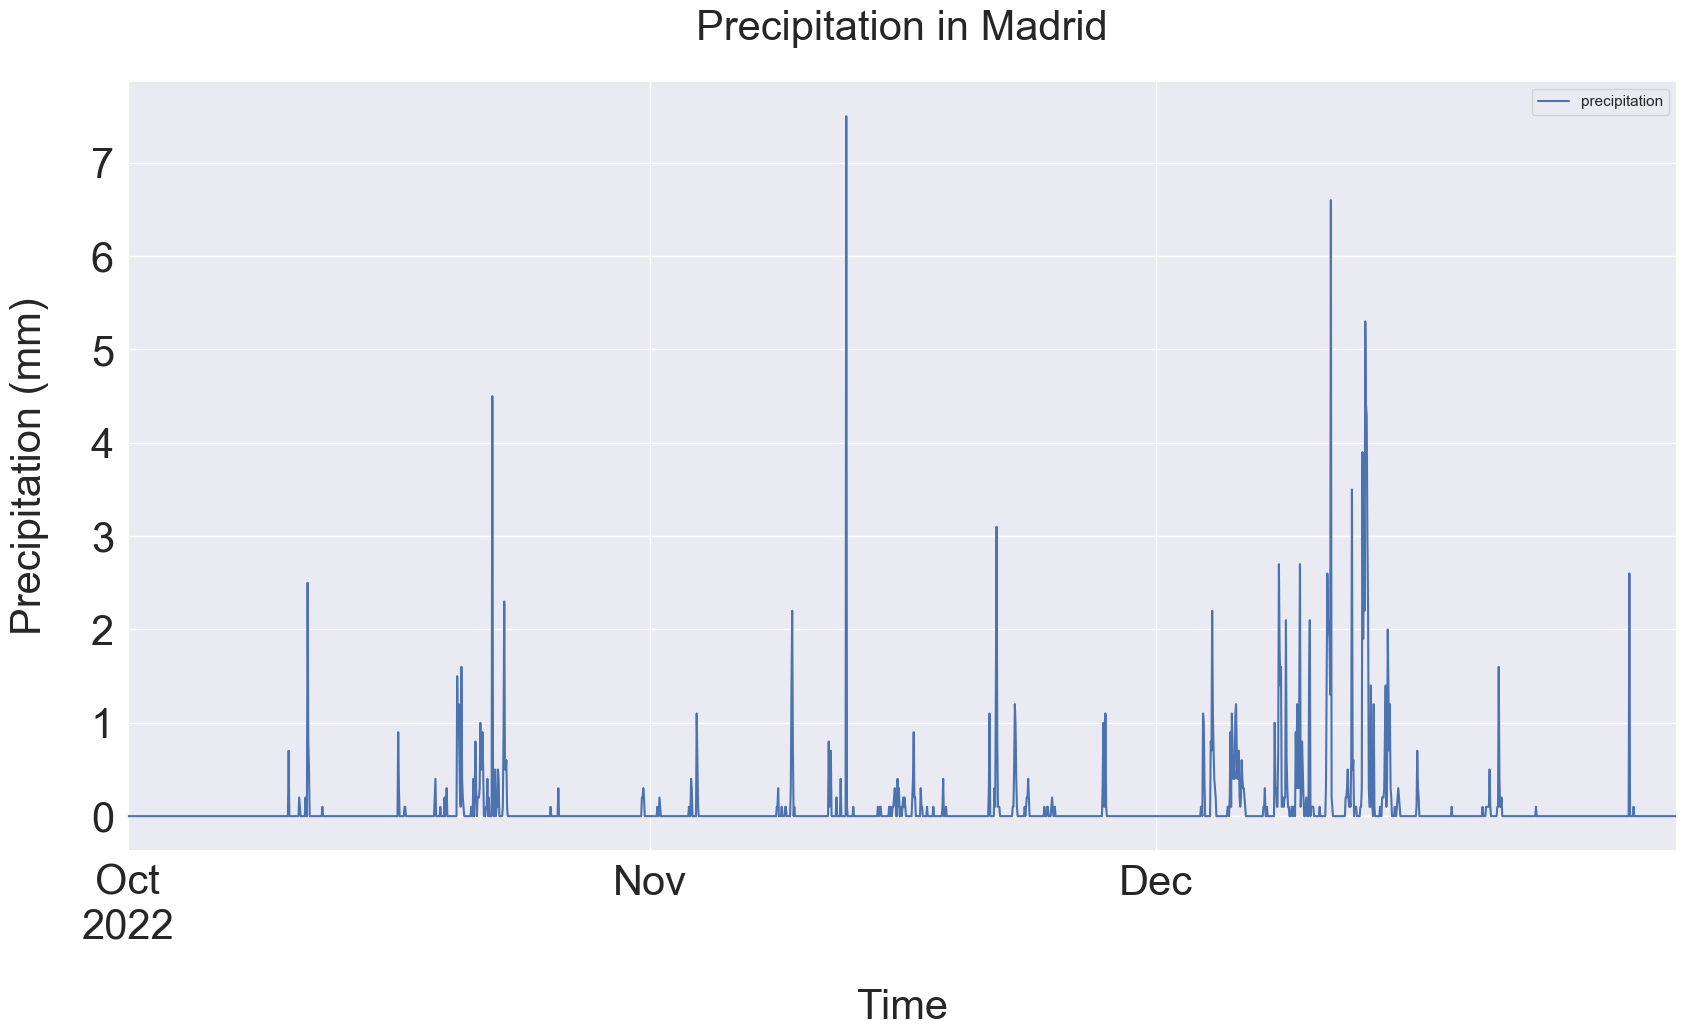

In [13]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.421501,
	"longitude": -3.680008,
	"start_date": "2022-10-01",
	"end_date": "2022-12-31",
	"hourly": "precipitation",
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_precipitation = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["precipitation"] = hourly_precipitation

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.set_index("date", inplace = True)
# plt.rcParams['axes.titlesize'] = 30
# plt.rcParams['axes.titlepad'] = 30
# # Set the size of the x-axis label
# plt.rcParams['axes.labelsize'] = 30
# plt.rcParams['axes.labelpad'] = 30
# # Set the size of the ticks
# plt.rcParams['xtick.labelsize'] = 30
# plt.rcParams['ytick.labelsize'] = 30

hourly_dataframe.plot(figsize=(20,10))
plt.ylabel('Precipitation (mm)')
plt.xlabel('Time')
plt.title("Precipitation in Madrid")
plt.show()


In [24]:
holidays = pd.read_csv('calendario.csv', sep=';', parse_dates=True, index_col='Dia', dayfirst=True)
holidays


,Dia_semana,laborable / festivo / domingo festivo,Tipo de Festivo,Festividad,Unnamed: 5,Unnamed: 6
Dia,,,,,,
2013-01-01,martes,festivo,Festivo nacional,Año Nuevo,NaN,NaN
2013-01-02,miercoles,laborable,NaN,NaN,NaN,NaN
2013-01-03,jueves,laborable,NaN,NaN,NaN,NaN
2013-01-04,viernes,laborable,NaN,NaN,NaN,NaN
2013-01-05,sabado,sabado,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-12-27,viernes,NaN,NaN,NaN,NaN,NaN
2024-12-28,sábado,NaN,NaN,NaN,NaN,NaN
2024-12-29,domingo,NaN,NaN,NaN,NaN,NaN


In [25]:
# Drop last two columns
holidays.drop(holidays.columns[-2:], axis=1, inplace=True)
holidays.dropna(inplace=True)

In [26]:
holidays

,Dia_semana,laborable / festivo / domingo festivo,Tipo de Festivo,Festividad
Dia,,,,
2013-01-01,martes,festivo,Festivo nacional,Año Nuevo
2013-01-07,lunes,festivo,Festivo nacional,Traslado Epifania del Señor
2013-03-18,lunes,festivo,Festivo de la Comunidad de Madrid,Traslado San Jose
2013-03-28,jueves,festivo,Festivo de la comunidad de Madrid,Jueves Santo
2013-03-29,viernes,festivo,Festivo nacional,Viernes Santo
...,...,...,...,...
2024-10-12,sábado,Festivo,Festivo nacional,Fiesta Nacional de España
2024-11-01,viernes,Festivo,Festivo nacional,Todos los Santos
2024-11-09,sábado,Festivo,Festivo local,Nuestra Señora de la Almudena


In [27]:
# Keep only the holidays from 01/10/2022 to 31/12/2022
holidays = holidays.loc['2022-10-01':'2023-01-01']

holidays

,Dia_semana,laborable / festivo / domingo festivo,Tipo de Festivo,Festividad
Dia,,,,
2022-10-12,miércoles,Festivo,Festivo nacional,Fiesta Nacional de España
2022-11-01,martes,Festivo,Festivo nacional,Todos los Santos
2022-11-09,miércoles,Festivo,Festivo local,Nuesta Señora de la Almudena
2022-12-06,martes,Festivo,Festivo nacional,Día de la Constitución Española
2022-12-08,jueves,Festivo,Festivo nacional,Inmaculada Concepcion
2022-12-26,lunes,Festivo,Festivo nacional,"traslado del descanso del 25 de diciembre, Nat..."


In [45]:
def get_access_token(passkey, xclientid):
    url = 'https://openapi.emtmadrid.es/v2/mobilitylabs/user/login/'
    headers = {'passKey': passkey, 'X-ClientId': xclientid}
    r = requests.get(url, headers=headers)
    return r.json()['data'][0]['accessToken']

In [46]:
def logout(access_token):
    url = 'https://openapi.emtmadrid.es/v2/mobilitylabs/user/logout/'
    headers = {'accessToken': access_token}
    r = requests.get(url, headers=headers)
    return r.json()

In [47]:
def get_stations(access_token):
    url = 'https://openapi.emtmadrid.es/v1/transport/bicimad/stations/'
    headers = {'accessToken': access_token}
    r = requests.get(url, headers=headers)
    return r.json()

In [48]:
def get_station(access_token, station_id):
    url = f'https://openapi.emtmadrid.es/v1/transport/bicimad/stations/{station_id}'
    headers = {'accessToken': access_token}
    r = requests.get(url, headers=headers)
    return r.json()

In [49]:
access_token = get_access_token(PASSKEY, XCLIENTID)
access_token

'70a9e224-a10c-11ee-ad1f-02dc46db3b2f'

In [50]:
stations = get_stations(access_token)
stations

{'code': '00',
 'description': '601 bases recovered',
 'datetime': '2023-12-22T21:55:39.093666',
 'data': [{'activate': 1,
   'address': 'Avenida del Ensanche de Vallecas, 9,',
   'dock_bikes': 9,
   'free_bases': 18,
   'geometry': {'type': 'Point', 'coordinates': [-3.61253028, 40.37043968]},
   'id': 2190,
   'light': 2,
   'name': '453 - Avenida del Ensanche de Vallecas, 9',
   'no_available': 0,
   'number': '453',
   'reservations_count': 0,
   'total_bases': 27,
   'virtualDelete': False,
   'geofenced_capacity': 20},
  {'activate': 1,
   'address': 'Paseo de la Chopera,33,Comunidad de Madrid España',
   'dock_bikes': 20,
   'free_bases': 3,
   'geometry': {'type': 'Point',
    'coordinates': [-3.7003996647238746, 40.39500000000003]},
   'id': 2205,
   'light': 1,
   'name': '267 - Paseo de la Chopera, 33',
   'no_available': 0,
   'number': '267',
   'reservations_count': 0,
   'total_bases': 23,
   'virtualDelete': False,
   'geofenced_capacity': 20},
  {'activate': 1,
   'addr

In [51]:
logout(access_token)

{'code': '03',
 'description': 'Token 70a9e224-a10c-11ee-ad1f-02dc46db3b2f removed  from control-cache Data recovered  OK, (lapsed: 529 millsecs)',
 'datetime': '2023-12-22T21:56:38.738734',
 'data': []}